In [36]:
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Markdown as md
import custom_rcparams

### With 100 points, three cases:

1. Ideal
2. Gaussian noise
3. Uniform noise

we have created a dataset with 100 points. The relation we want to investigate is

$$
2.5382 cos(x)+x^2-0.5
$$

In [123]:
import numpy as np

X2 = 5 * np.random.randn(100,1)
X = X2.reshape(-1)
a = 2 #weight for noise
y = 2.5382 * np.cos(X) + X ** 2 - 0.5 
n = y + a*np.random.randn(100)
u = y + a*np.random.rand(100)

In [121]:
print(n)

[ 77.43242119  -0.79931233   2.55479482   2.95468021   2.01307226
   7.76534872   8.93299469   3.7267097    1.87622327   3.5262917
  19.25100537  24.88893731  26.34565346  14.20580352  63.33920642
  50.4571134    9.07021984   0.31925108  64.56557286  24.98047369
   0.4727271    0.87471488   2.45205498   0.30750966  -0.35580392
  53.86361254   5.37030344  12.13641943  55.5183541   22.08986595
  -0.93996417  87.96460534  19.77416247  38.67489333   7.48193513
  22.49789351  85.23933975   7.30562379 146.75614087   4.75607728
  11.57050196   3.60610075  43.89521573  73.44110253   3.81551093
  81.87964264  37.43769167  22.01032092  28.62291712   7.08459902
  12.982649    54.62648365  62.42644808   3.1772615   44.35983177
   5.79769312  80.99221546   7.29230982  16.92326264   3.29853692
  22.2966223   22.01537767   1.52546213  11.85994361   3.23435261
  -0.3167212    1.47053793  59.28490533  19.10985802  31.37843334
  30.46061572  20.33109427   4.0236853   30.2406681    1.60918108
  21.325731

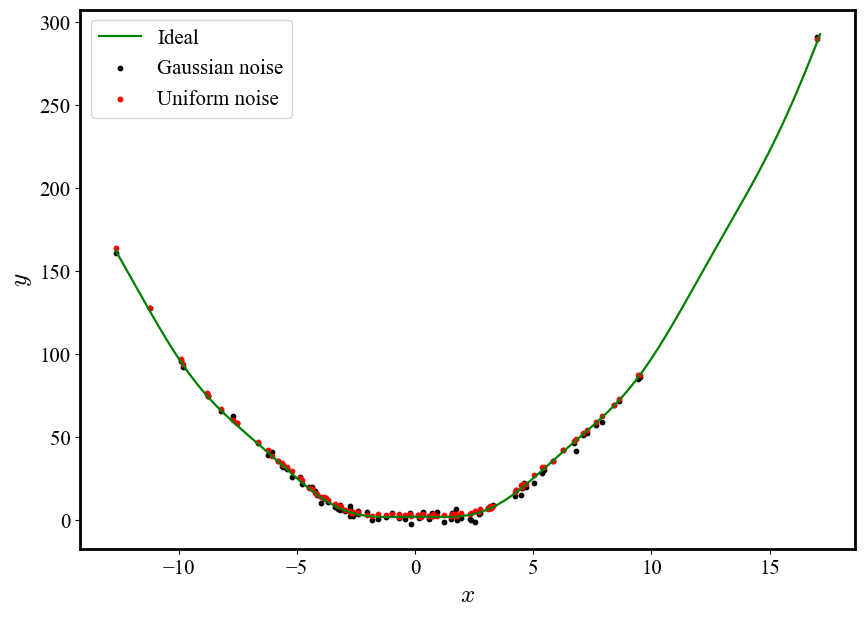

In [124]:
x = np.arange(np.min(X),np.max(X)+0.2, 0.2)
g = 2.5382 * np.cos(x) + x ** 2 - 0.5 
plt.plot(x,g, label='Ideal', color='g')
plt.scatter(X,n, label='Gaussian noise',s=10, color='k')
plt.scatter(X,u, label='Uniform noise',s=10,color='r')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.savefig('xcosx.pdf')

from pysr import PySRRegressor

model = PySRRegressor(
    niterations=40,  # < Increase me for better results
    binary_operators=["+", "*"],
    unary_operators=[
        "cos",
        "exp",
        "sin",
        "inv(x) = 1/x",
        # ^ Custom operator (julia syntax)
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)    
    procs=8,
)

In [39]:
from pysr import PySRRegressor

model = PySRRegressor(
    niterations=40,  # < Increase me for better results
    binary_operators=["+", "*"],
    unary_operators=[
        "cos",
        "sin",
        "exp",
        "log",
    ],
    loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)    
    warm_start=True,
    turbo=True,
    #batching=True, not so useful for this example
)

In [40]:
def error(data, model):
    if len(data) != len(model):
        print('ERROR: array must have the same length!')
        return

    l = len(data)
    error = np.zeros(l)  # Inizializza un array numpy di zeri della stessa lunghezza di data e model

    for i in range(l):
        if data[i] != 0:
            error[i] = 100 * abs((data[i] - model[i]) / data[i])

    return error


In [153]:
def accuracy(data, model):
    if len(data) != len(model):
        print('ERROR: array must have the same length!')
        return
    
    l = len(data)
    total_error = 0
    
    for i in range(l):
        if data[i] == 0:
            error = 0 
        else:
            error = ((data[i] - model[i]))
        total_error += error
    
    avg_error = total_error / l
    accuracy_percentage =  (avg_error)
    
    return accuracy_percentage


## 1. Ideal


In [125]:
model.fit(X2, y)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	   pick         score                                           equation  \
	0        0.000000e+00                                          26.370934   
	1        6.251001e-08                                     exp(3.2721593)   
	2        6.047662e+00                                          (x0 * x0)   
	3        5.447243e-02                          ((x0 * x0) + -0.62482184)   
	4        7.657859e-01                              ((x0 * x0) + cos(x0))   
	5        9.230391e-01                ((x0 * x0) + (cos(x0) * 2.5846605))   
	6  >>>>  1.185467e+01  ((x0 * x0) + ((cos(x0) + -0.19698991) * 2.5382...   
	
	           loss  complexity  
	0  1.599744e+03           1  
	1  1.599744e+03           2  
	2  3.780802e+00           3  
	3  3.390547e+00           5  
	4  1.576497e+00           6  
	5  2.488580e-01           8  
	6  1.256367e-11          10  
]

In [43]:
p_1 = model.predict(X)
l_1 = model.latex()
p=[]
l=[]
p.append(p_1), l.append(l_1)

(None, None)

In [126]:
print('offset: ', accuracy(y,model.predict(X2)))
print('equation: ', model.latex())

offset:  -1.8582595302518712e-05
equation:  x_{0}^{2} + 2.54 \cos{\left(x_{0} \right)} - 0.500


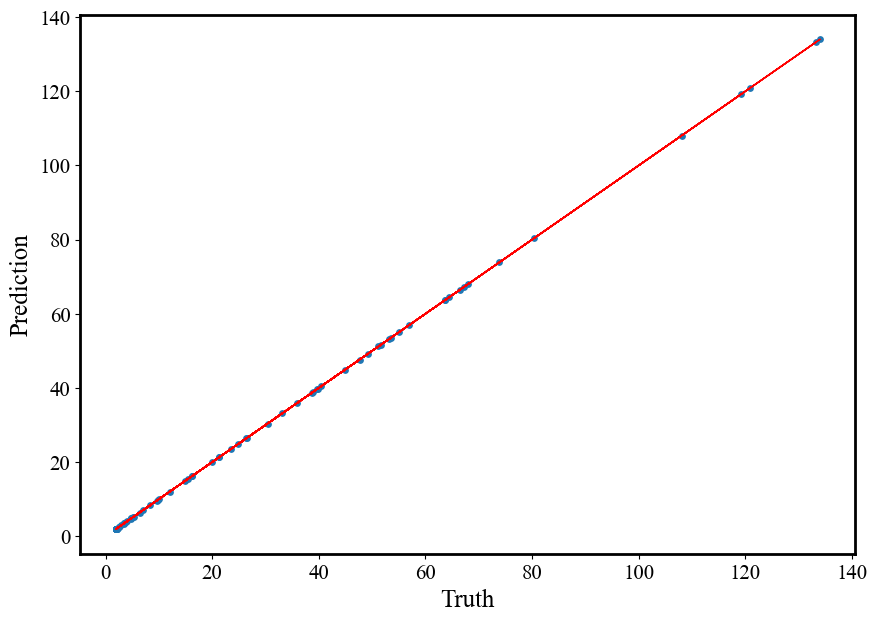

In [45]:
plt.scatter(y, p_1,s=15)
plt.plot(y,y, color='r', lw=1)
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.show()

In [46]:
md(f"The model has this equation as output: ${l[0]}$")

The model has this equation as output: $1.00 x_{0}^{2} + 2.54 \cos{\left(x_{0} \right)} - 0.500$

## 2. Gaussian noise


In [128]:
model.fit(X2,n)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                          26.263418   
	1         2.686429e+00                                          (x0 * x0)   
	2         3.731717e-02                           ((x0 * x0) + -0.7330375)   
	3         2.702258e-01                              ((x0 * x0) + cos(x0))   
	4   >>>>  1.393148e-01                ((x0 * x0) + (cos(x0) * 2.5382001))   
	5         5.403341e-05           ((x0 * x0) + (exp(0.9430567) * cos(x0)))   
	6         9.687782e-02  (((x0 * x0) + -0.6060459) + (cos(x0) * 2.53820...   
	7         3.944923e-07  (((x0 * x0) + sin(2.5382001)) + ((cos(x0) + -0...   
	8         1.319802e-04  (((x0 * x0) + (cos(x0) * 2.510637)) + ((0.6385...   
	9         1.622260e-03  (((((x0 + -1.0718578) * x0) + (cos(x0) + x0)) ...   
	10        3.195721e-04  (((x0 * x0) + (cos(0.048671797 + x0) * 2.51063...   
	11        1.523357e-02  (((x0 * x0) + sin(cos(x0) * x0)) + ((sin(cos(x...   
	12        7.137437e-03  (((x0 * x0) + sin((cos(sin(-1.0225807)) * -0.0...   
	
	           loss  complexity  
	0   1609.111800           1  
	1      7.467651           3  
	2      6.930599           5  
	3      5.289483           6  
	4      4.003187           8  
	5      4.002971           9  
	6      3.633364          10  
	7      3.633360          13  
	8      3.632880          14  
	9      3.626991          15  
	10     3.625833          16  
	11     3.571017          17  
	12     3.520403          19  
]

In [136]:
print('offset: ', accuracy(y,model.predict(X2)))
print('equation: ', model.latex())

offset:  -49.999999508694366
equation:  x_{0}^{2} + 2.54 \cos{\left(x_{0} \right)}


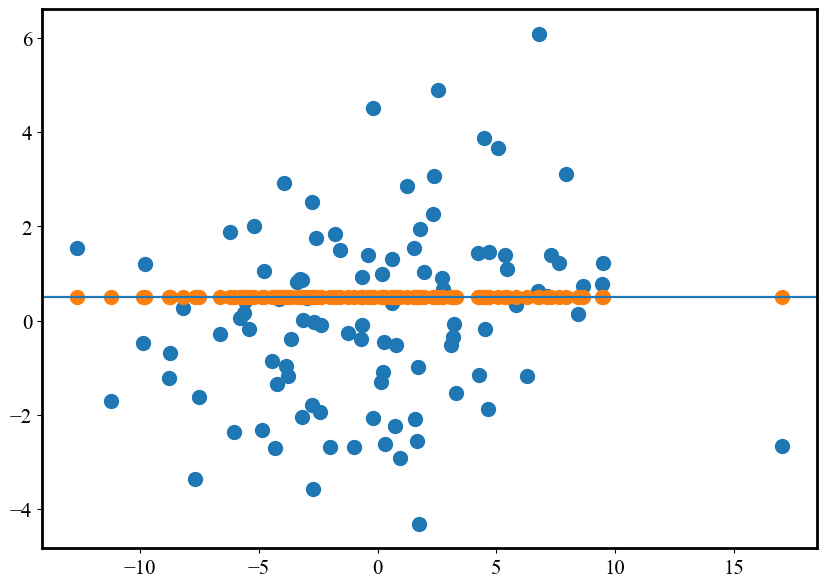

In [134]:
plt.scatter(X,y-n)
plt.scatter(X,np.array(model.predict(X2))-y)
plt.axhline(0.5)

ValueError: x and y must be the same size

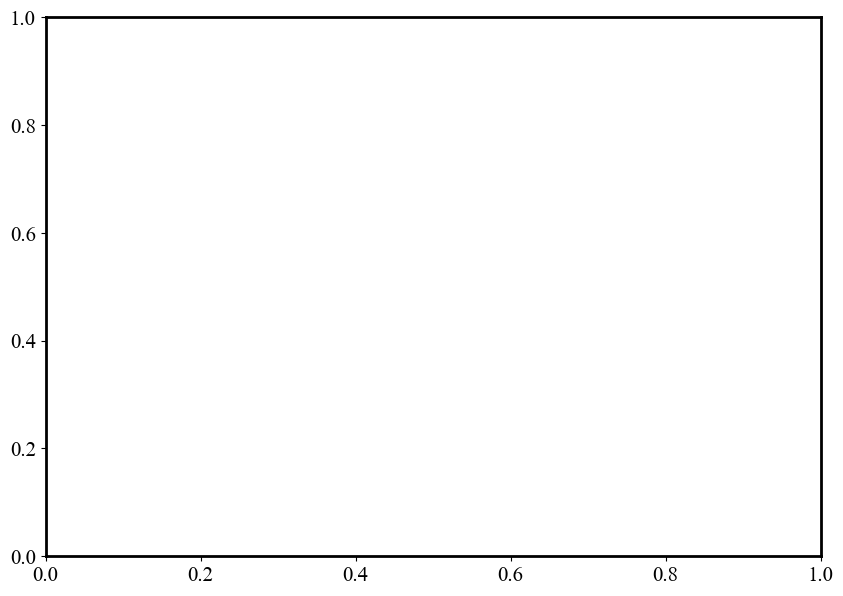

In [98]:
plt.scatter(X,vettore)

In [83]:
p_2 = model.predict(X)
l_2 = model.latex()
p.append(p_2), l.append(l_2)

AttributeError: 'int' object has no attribute 'append'

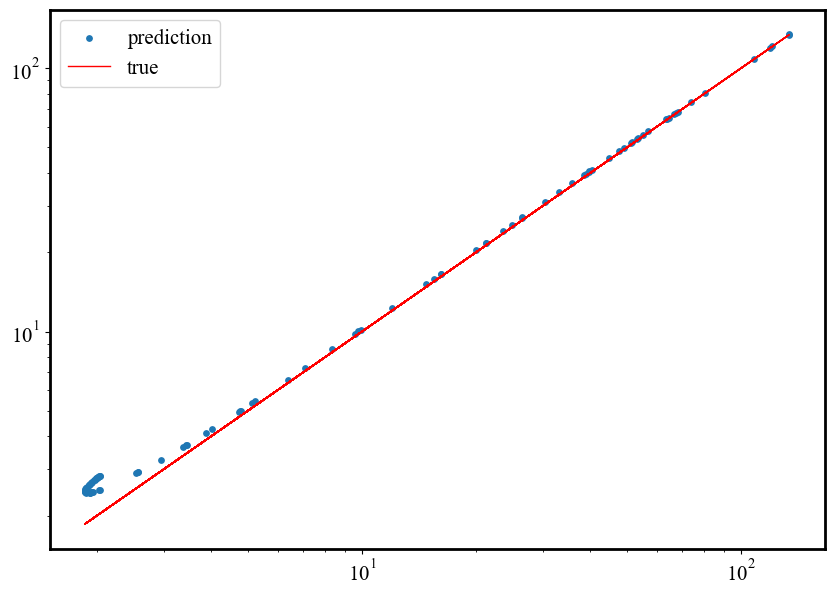

In [87]:
plt.scatter(y, model.predict(X),s=15, label='prediction')
plt.loglog(y,y, color='r', lw=1, label='true')
plt.legend()
plt.show()

In [51]:
md(f"The model has this equation as output: ${l[1]}$")

The model has this equation as output: $x_{0}^{2} + 2.84 \cos{\left(x_{0} \right)}$

## 3. Uniform noise

In [144]:
model.fit(X2,u)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          27.280693   
	1         3.020914                                          (x0 * x0)   
	2         0.010704                           ((x0 * x0) + 0.28439635)   
	3         0.791269                              ((x0 * x0) + cos(x0))   
	4         0.620259                ((x0 * x0) + (2.5092242 * cos(x0)))   
	5   >>>>  0.202173  ((x0 * x0) + (2.5092242 * (cos(x0) + 0.1398643...   
	6         0.004483  (((x0 * x0) + 0.66830647) + ((2.5092242 * cos(...   
	7         0.000455  ((x0 * x0) + (((2.5092242 * cos(x0)) + -0.5441...   
	8         0.000008  ((x0 * x0) + (((2.5092242 * cos(x0)) + -0.5441...   
	9         0.031109  ((((x0 * x0) + cos(x0)) + cos(exp(-0.6481517 *...   
	10        0.012195  (((((x0 * x0) + cos(x0)) + cos(x0)) + -0.17801...   
	11        0.000018  (((((x0 * x0) + cos(x0)) + cos(x0 + 0.05519305...   
	
	           loss  complexity  
	0   1606.442400           1  
	1      3.818847           3  
	2      3.737962           5  
	3      1.694303           6  
	4      0.490050           8  
	5      0.327066          10  
	6      0.324146          12  
	7      0.323851          14  
	8      0.323849          15  
	9      0.313929          16  
	10     0.310124          17  
	11     0.310113          19  
]

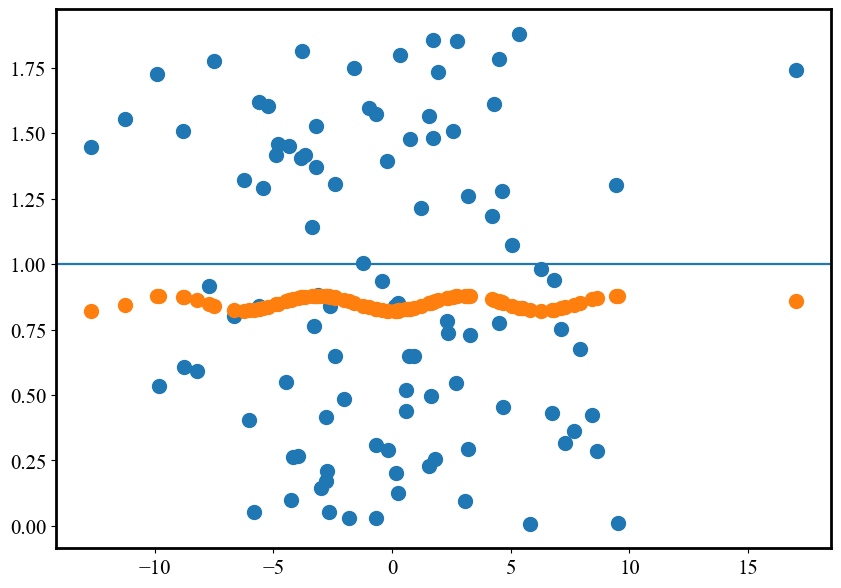

In [145]:
plt.scatter(X,u-y)
plt.scatter(X,np.array(model.predict(X2))-y)
plt.axhline(1)

In [146]:
print('accuracy: ', accuracy(y,model.predict(X2)))
print('equation: ', model.latex())

accuracy:  -85.23747096148728
equation:  x_{0}^{2} + 2.51 \cos{\left(x_{0} \right)} + 0.351


In [ ]:
p_3 = model.predict(X)
l_3 = model.latex()
p.append(p_3), l.append(l_3)

(None, None)

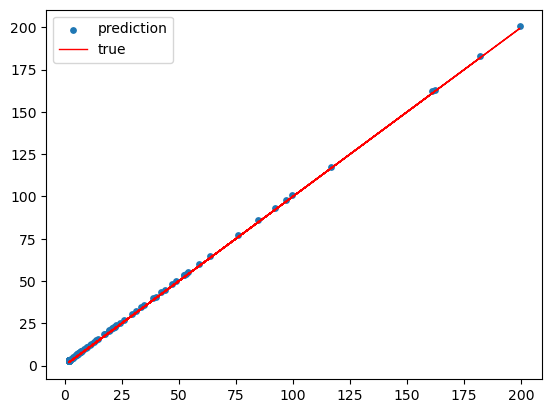

In [ ]:
plt.scatter(y, p_3,s=15, label='prediction')
plt.plot(y,y, color='r', lw=1, label='true')
plt.legend()
plt.show()

In [ ]:
md(f"The model has this equation as output: ${l[2]}$")

The model has this equation as output: $x_{0}^{2} + 2.46 \cos{\left(x_{0} \right)} + 0.626$

## Comparison beetween ideal and noised

Gaussian

I compute the diferences between ideal and noised data, and later I used the discovered formulas to do the same:

In [ ]:
d_1 = y-n 
d_2 = p_1-p_2

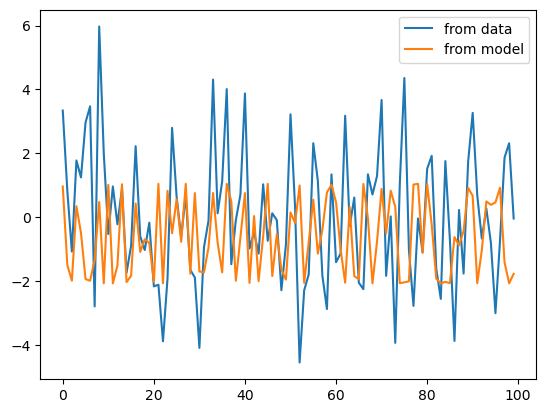

In [ ]:
plt.plot(d_1, label='from data')
plt.plot(d_2, label='from model')
plt.legend()

seems that the model reduces the discrepances between ideal data and gaussian-noised data: I think that's fine because we find in both cases two formulas very similar. ($ x^2+a\cdot cos(x)+ b$, where  $a, b \in \mathbb{R}$)


Uniform

In [ ]:
r_1 = y-u
r_2 = p_1-p_3

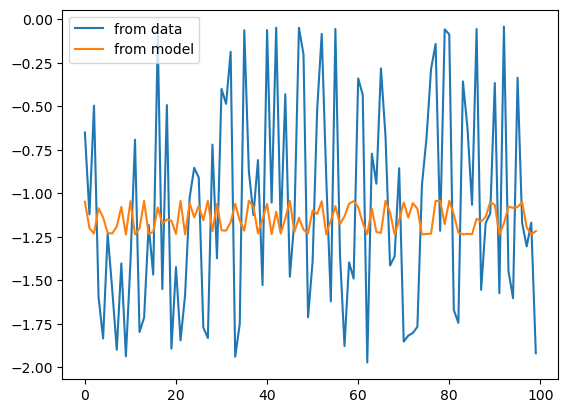

In [ ]:
plt.plot(r_1, label='from data')
plt.plot(r_2, label='from model')
plt.legend()

## Tryhard #1: using only 50 points

In [ ]:
X = 5 * np.random.randn(50,1)
y = 2.5382 * np.cos(X) + X ** 2 - 0.5 
n = y + a*np.random.randn(50,1)
u = y + a*np.random.rand(50,1)

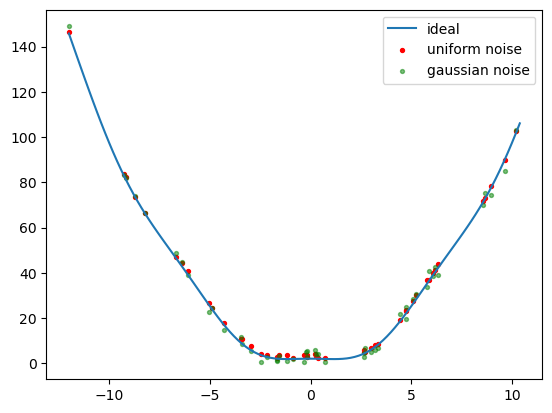

In [ ]:
x = np.arange(np.min(X),np.max(X)+0.2, 0.2)
g = 2.5382 * np.cos(x) + x ** 2 - 0.5 
plt.plot(x,g, label='ideal')
plt.scatter(X,u, label='uniform noise', color='r', s=8)
plt.scatter(X,n, label='gaussian noise', color='green', s=8, alpha=0.5)
plt.legend()

Ideal

In [ ]:
model.fit(X, y)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                           29.17423   
	1         2.774637e+00                                          (x0 * x0)   
	2         4.319562e-02                            ((x0 * 0.9867062) * x0)   
	3         8.244341e-01                              ((x0 * x0) + cos(x0))   
	4         9.615644e-01                ((x0 * x0) + (cos(x0) * 2.5254734))   
	5         1.996625e+00  (((x0 * x0) + -0.53199434) + (cos(x0) * 2.4634...   
	6         2.530190e-01  (((x0 * x0) + sin(-0.53199434)) + (cos(x0) * 2...   
	7         2.934649e-07  (((x0 * x0) + log(exp(sin(-0.53199434)))) + (c...   
	8         9.088254e-03  (((x0 * x0) + (cos(x0) + (cos(x0) * 1.6124839)...   
	9         2.095560e-01  (((x0 * x0) + (sin(cos(x0)) + (cos(x0) * 1.612...   
	10        3.736608e-05  (((x0 * x0) + (sin(cos(x0)) + (cos(x0) * 1.612...   
	11  >>>>  1.941529e+00  ((((x0 * x0) + 0.10109275) + -1.2379838) + ((l...   
	
	           loss  complexity  
	0   1092.831800           1  
	1      4.251426           3  
	2      3.899558           5  
	3      1.709890           6  
	4      0.249899           8  
	5      0.004608          10  
	6      0.003578          11  
	7      0.003578          13  
	8      0.003482          16  
	9      0.002823          17  
	10     0.002823          18  
	11     0.000405          19  
]

In [ ]:
l_4 = model.latex()
p_4 = model.predict(X)
p.append(p_4), l.append(l_4)

(None, None)

In [ ]:
md(f"The model has this equation as output: ${l[3]}$")

The model has this equation as output: $x_{0}^{2} + 2.53 \log{\left(e^{\cos{\left(x_{0} \right)}} \right)} - 0.481$

Gaussian

In [ ]:
model.fit(X, n)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          29.494015   
	1         2.284255                                          (x0 * x0)   
	2         0.008093                            ((x0 * x0) * 0.9904284)   
	3         0.377454                              ((x0 * x0) + cos(x0))   
	4   >>>>  0.337189                ((x0 * x0) + (cos(x0) * 3.4490428))   
	5         0.010079  ((x0 * (x0 + -0.05217419)) + (3.4490817 * cos(...   
	6         0.002421  (((x0 * (x0 + -0.044002667)) + (cos(x0) * 3.44...   
	7         0.019891  ((x0 * x0) + ((cos(exp(3.4490817) * x0) + 3.44...   
	8         0.044234  ((x0 * x0) + ((cos(exp(sin(x0 * x0))) + 3.4490...   
	9         0.001244  ((x0 * x0) + (((sin(exp(x0) * x0) * cos(x0)) +...   
	10        0.026365  ((x0 * x0) + ((cos(exp(cos(exp(sin(exp(x0)))) ...   
	11        0.038296  ((x0 * x0) + ((cos(exp(cos(sin(x0)) + 3.449081...   
	
	           loss  complexity  
	0   1096.247700           1  
	1     11.371832           3  
	2     11.189247           5  
	3      7.671400           6  
	4      3.908373           8  
	5      3.830380          10  
	6      3.802665          13  
	7      3.727775          14  
	8      3.566475          15  
	9      3.557615          17  
	10     3.465044          18  
	11     3.334853          19  
]

In [ ]:
l_4 = model.latex()
p_4 = model.predict(X)
p.append(p_4), l.append(l_4)

(None, None)

In [ ]:
md(f"The model has this equation as output: ${l[4]}$")

The model has this equation as output: $x_{0}^{2} + 3.45 \cos{\left(x_{0} \right)}$

uniform

In [ ]:
model.fit(X, u)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          30.152807   
	1         2.680674                                          (x0 * x0)   
	2         0.026831                             ((x0 * x0) + 0.515567)   
	3         0.726080                              ((x0 * x0) + cos(x0))   
	4         0.739707                ((x0 * x0) + (cos(x0) * 2.6938977))   
	5   >>>>  0.246547  ((x0 * x0) + ((cos(x0) * 2.5994072) + 0.5846875))   
	6         0.020307  ((x0 * x0) + ((cos(x0) + 0.14739555) * exp(0.9...   
	7         0.036146  (((x0 * x0) + (sin(sin(cos(x0))) * 3.4490428))...   
	8         0.001137  (((x0 * x0) + (sin(sin(cos(x0))) * 3.4490428))...   
	9         0.002698  (((x0 * x0) + (sin(cos(x0)) * ((3.4490428 + -1...   
	10        0.001780  (((x0 * x0) + (sin(cos(x0)) * ((3.4490428 + -1...   
	11        0.001037  (((x0 * x0) + (sin(cos(x0 + 0.018665861)) * ((...   
	12        0.010581  (((x0 * (x0 + -1.0160795)) + x0) + ((cos(x0) *...   
	
	           loss  complexity  
	0   1082.956500           1  
	1      5.084023           3  
	2      4.818396           5  
	3      2.331148           6  
	4      0.530968           8  
	5      0.324280          10  
	6      0.317762          11  
	7      0.306481          12  
	8      0.306133          13  
	9      0.304485          15  
	10     0.303944          16  
	11     0.303314          18  
	12     0.300121          19  
]

In [ ]:
l_4 = model.latex()
p_4 = model.predict(X)
p.append(p_4), l.append(l_4)
md(f"The model has this equation as output: ${l[5]}$")

The model has this equation as output: $x_{0}^{2} + 2.60 \cos{\left(x_{0} \right)} + 0.585$

It seems that the gaussian noise has a greater disturbance on the data, in fact the expression that I found is slightly different from the ideal one. The model suffers a bit with gaussian noise, while the model is reliable with the uniform noise

## Tryhard: 5(or 2) variables



In [147]:
X = 5 * np.random.randn(100, 2)
a = 2 #weight for noise
y = 2.5382 * np.cos(X[:,1]) + X[:,0] ** 2 - 0.5
n = y + a*np.random.randn(100)
u = y + a*np.random.rand(100)

we have created a dataset with 100 points with 2 features each. The relation we want to investigate is

$$
2.5382 cos(x_1)+x_0^2-0.5
$$

## 1. Ideal

In [148]:
model.fit(X,y)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                          27.369337   
	1        3.051162                                          (x0 * x0)   
	2        0.005304                          ((x0 * x0) + -0.18308605)   
	3        0.922763                              ((x0 * x0) + cos(x1))   
	4        0.804649                   ((x0 * x0) + (cos(x1) * 2.5382))   
	5        0.745644  (((x0 * x0) + -0.43853065) + (cos(x1) * 2.8461...   
	6        1.701265  (((x0 * x0) + -0.43853065) + (sin(cos(x1)) * 2...   
	7        1.416921  ((((x0 * x0) + cos(-1.2129968)) + (cos(x1) * 2...   
	8  >>>>  3.507743  (((((x0 * x0) + (-0.25938702 * -1.8329201)) + ...   
	
	           loss  complexity  
	0  1.420405e+03           1  
	1  3.178387e+00           3  
	2  3.144850e+00           5  
	3  1.249825e+00           6  
	4  2.500001e-01           8  
	5  5.627068e-02          10  
	6  1.026673e-02          11  
	7  6.035459e-04          13  
	8  1.457951e-11          18  
]

In [154]:
print('accuracy: ', accuracy(y,model.predict(X)))
print('equation: ', model.latex())

accuracy:  0.0024382096834725735
equation:  x_{0}^{2} + 2.53 \cos{\left(x_{3} \right)} - 0.502


In [ ]:
l_5 = model.latex()
p_5 = model.predict(X)
p.append(p_5), l.append(l_5)
md(f"The model has this equation as output: ${l[6]}$")

The model has this equation as output: $x_{0}^{2} + 2.60 \cos{\left(x_{1} \right)} - 0.485$

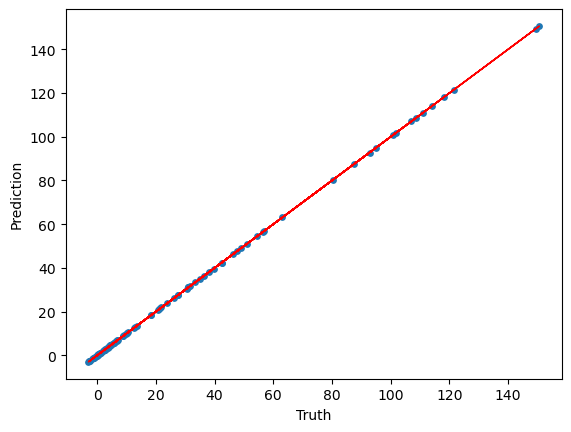

In [ ]:
plt.scatter(y, p[6],s=15)
plt.plot(y,y, color='r', lw=1)
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.show()

## 2. Gaussian

In [155]:
model.fit(X,n)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          19.668978   
	1         2.392463                                          (x0 * x0)   
	2         0.020577                          ((x0 + -0.12426906) * x0)   
	3   >>>>  0.239206                              ((x0 * x0) + cos(x3))   
	4         0.104211                ((2.4518783 * cos(x3)) + (x0 * x0))   
	5         0.000824           ((x0 * x0) + (cos(x3) * exp(0.9290221)))   
	6         0.060151  (((2.4518783 * cos(x3)) + (x0 * x0)) + -0.5461...   
	7         0.002406  (((x0 * x0) + (cos(x3) * exp(1.0016936))) + -0...   
	8         0.000401  ((x0 * x0) + ((cos(x3) * exp(cos(sin(-0.127758...   
	9         0.003449  (((x0 * x0) + (cos(x3) * exp(cos(sin(exp(x4)))...   
	10        0.046806  (((x0 * (x0 + -0.11659101)) + (cos(x3) * exp(s...   
	11        0.008954  (((x0 * (x0 + -0.11659101)) + (cos(x3) * exp(c...   
	12        0.000018  (((x0 * (x0 + sin(-0.11659101))) + (cos(x3) * ...   
	13        0.004196  (((x0 * (x0 + sin(-0.11659101))) + (cos(x3) * ...   
	
	          loss  complexity  
	0   916.326230           1  
	1     7.655662           3  
	2     7.346998           5  
	3     5.783945           6  
	4     4.695781           8  
	5     4.691912           9  
	6     4.418008          10  
	7     4.407393          11  
	8     4.403863          13  
	9     4.388701          14  
	10    4.188018          15  
	11    4.150686          16  
	12    4.150611          17  
	13    4.133232          18  
]

In [156]:
print('accuracy: ', accuracy(y,model.predict(X)))
print('equation: ', model.latex())

accuracy:  -0.3784499812479314
equation:  x_{0}^{2} + \cos{\left(x_{3} \right)}


In [ ]:
l_5 = model.latex()
p_5 = model.predict(X)
p.append(p_5), l.append(l_5)
md(f"The model has this equation as output: ${l[7]}$")

The model has this equation as output: $x_{0}^{2} + 3.05 \cos{\left(x_{1} \right)}$

## 3. Uniform

In [157]:
model.fit(X,u)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                          20.725517   
	1        2.728733                                          (x0 * x0)   
	2        0.073017                           ((x0 * x0) + 0.72254694)   
	3        0.586730                              ((x0 * x0) + cos(x3))   
	4        0.106166                         ((x0 * x0) + exp(cos(x3)))   
	5        1.092956                ((x0 * x0) + (2.5972083 * cos(x3)))   
	6  >>>>  0.327754  (((x0 * x0) + (2.5972083 * cos(x3))) + 0.5178024)   
	7        0.000011  (((x0 * x0) + (2.5972083 * (cos(x3) * cos(exp(...   
	
	         loss  complexity  
	0  901.453740           1  
	1    3.844109           3  
	2    3.321805           5  
	3    1.847398           6  
	4    1.661321           7  
	5    0.556914           8  
	6    0.289138          10  
	7    0.289124          14  
]

In [ ]:
l_5 = model.latex()
p_5 = model.predict(X)
p.append(p_5), l.append(l_5)
md(f"The model has this equation as output: ${l[8]}$")

The model has this equation as output: $x_{0}^{2} + 2.71 \cos{\left(x_{1} \right)} + 0.573$

In [158]:
print('accuracy: ', accuracy(y,model.predict(X)))
print('equation: ', model.latex())

accuracy:  -1.0224652916730772
equation:  x_{0}^{2} + 2.60 \cos{\left(x_{3} \right)} + 0.518


## 5 (3 fake) variables

In [150]:
X = 5 * np.random.randn(100, 5)
a = 2 #weight for noise
y = 2.5382 * np.cos(X[:,3]) + X[:,0] ** 2 - 0.5
n = y + a*np.random.randn(100)
u = y + a*np.random.rand(100)

we have created a dataset with 100 points with 5 features each. The relation we want to investigate is

$$
2.5382 cos(x_3)+x_0^2-0.5
$$

### Ideal

In [151]:
model.fit(X,y)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                          19.704052   
	1        2.851805                                          (x0 * x0)   
	2        0.015180                          ((x0 * x0) + -0.29943258)   
	3        0.875860                              ((x0 * x0) + cos(x3))   
	4        0.795904                ((2.4518783 * cos(x3)) + (x0 * x0))   
	5        1.843747  (((2.4518783 * cos(x3)) + (x0 * x0)) + -0.5461...   
	6  >>>>  5.587216  (((x0 * x0) + (cos(x3) * exp(0.9290221))) + -0...   
	
	         loss  complexity  
	0  899.291100           1  
	1    2.998156           3  
	2    2.908497           5  
	3    1.211400           6  
	4    0.246589           8  
	5    0.006173          10  
	6    0.000023          11  
]

In [152]:
print('accuracy: ', accuracy(y,model.predict(X)))
print('equation: ', model.latex())

accuracy:  0.24382096834725733
equation:  x_{0}^{2} + 2.53 \cos{\left(x_{3} \right)} - 0.502


In [ ]:
l_5 = model.latex()
p_5 = model.predict(X)
p.append(p_5), l.append(l_5)
md(f"The model has this equation as output: ${l[9]}$")

The model has this equation as output: $x_{0}^{2} + 2.54 \cos{\left(x_{3} \right)} - 0.511$

### Gaussian noise


In [ ]:
model.fit(X,n)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                          24.745422   
	1        2.340069                                          (x0 * x0)   
	2        0.083953                           ((x0 * x0) + -1.0181597)   
	3  >>>>  0.084484                              ((x0 * x0) + cos(x3))   
	4        0.079191              ((x0 * x0) + (cos(x3) + -0.87371486))   
	5        0.029313          (((x0 * x0) + exp(cos(x3))) + -2.0442004)   
	6        0.051533  (((x0 * x0) + -0.83492136) + (cos(x3) * 1.8487...   
	7        0.001693  (((x0 * x0) + sin(-0.83492136)) + (cos(x3) * 1...   
	8        0.003337  (((x0 * x0) + cos(x3)) + (exp(cos(x3)) + log(l...   
	9        0.000296  (((x0 * x0) + cos(x3)) + (exp(sin(cos(x3))) + ...   
	
	         loss  complexity  
	0  722.975340           1  
	1    6.707570           3  
	2    5.670800           5  
	3    5.211386           6  
	4    4.448038           8  
	5    4.319543           9  
	6    4.102584          10  
	7    4.095643          11  
	8    4.054844          14  
	9    4.053646          15  
]

In [ ]:
l_5 = model.latex()
p_5 = model.predict(X)
p.append(p_5), l.append(l_5)
md(f"The model has this equation as output: ${l[10]}$")

The model has this equation as output: $x_{0}^{2} + \cos{\left(x_{3} \right)}$

### Uniform noise

In [ ]:
model.fit(X,u)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          25.867403   
	1         2.744788                                          (x0 * x0)   
	2         0.005958                            (x0 * (x0 * 1.0050735))   
	3         0.788825                              ((x0 * x0) + cos(x3))   
	4         0.359246                ((x0 * x0) + (cos(x3) * 1.8898817))   
	5         0.108899           ((x0 * x0) + (cos(x3) * exp(0.8596847)))   
	6         0.105624  ((x0 * x0) + ((cos(x3) * 1.8898817) + 0.246426...   
	7   >>>>  0.127931     ((((x0 * x0) + cos(x3)) + cos(x3)) + 0.374071)   
	8         0.074133  (((x0 * x0) + 0.40610534) + (exp(sin(1.571487)...   
	9         0.097653  (((x0 * x0) + 0.40610534) + (exp(sin(cos(-0.09...   
	10        0.001243  (((x0 * x0) + 0.40610534) + (exp(sin(cos(cos(1...   
	
	          loss  complexity  
	0   716.243040           1  
	1     2.957793           3  
	2     2.922759           5  
	3     1.328039           6  
	4     0.647402           8  
	5     0.580603           9  
	6     0.522405          10  
	7     0.459672          11  
	8     0.426827          12  
	9     0.387117          13  
	10    0.386636          14  
]

In [ ]:
l_5 = model.latex()
p_5 = model.predict(X)
p.append(p_5), l.append(l_5)
md(f"The model has this equation as output: ${l[11]}$")

The model has this equation as output: $x_{0}^{2} + 2 \cos{\left(x_{3} \right)} + 0.374$

It seems that the model fails with gaussian noise, both with one variable and with two variables. The model is anyway solid with uniform noise. 

Now we can try to increase the number of data, to see if the model can recover the expression that we want.

### fix #1: increasing the points

In [168]:
X = 5 * np.random.randn(1000, 5)
a = 2 #weight for noise
y = 2.5382 * np.cos(X[:,3]) + X[:,0] ** 2 - 0.5
n = y + a*np.random.randn(1000)
u = y + a*np.random.rand(1000)
model.fit(X,y)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!

Expressions evaluated per second: 2.190e+05
Head worker occupation: 10.9%
Progress: 466 / 600 total iterations (77.667%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.325e+03  2.762e-07  25.38215
2           1.325e+03  1.191e-07  exp(3.2338903)
3           3.313e+00  5.992e+00  (x0 * x0)
5           3.104e+00  3.265e-02  ((x0 * x0) + -0.45796654)
6           1.365e+00  8.216e-01  ((x0 * x0) + cos(x3))
8           2.499e-01  8.489e-01  ((x0 * x0) + (cos(x3) * 2.518))
10          1.510e-02  1.403e+00  (((x0 * x0) + (cos(x3) * 2.6448476)) + -0.4036805)
12          9.952e-03  2.086e-01  (((x0 * x0) + ((cos(x3) * 2.6448476) + -0.23409016)) + -0.2008...
                                  1455)
14          7.185e-03  1.628e-01  ((x0 * x0) + ((cos(x3) * 2.6448476) + sin(cos(exp(sin(0.895285...
                                  1))))))
15          5.704e-03  2.309

PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                           25.38215   
	1         7.544427e-08                                     exp(3.2338903)   
	2         5.991702e+00                                          (x0 * x0)   
	3         3.264528e-02                          ((x0 * x0) + -0.45796654)   
	4         8.215576e-01                              ((x0 * x0) + cos(x3))   
	5         8.489191e-01                    ((x0 * x0) + (cos(x3) * 2.518))   
	6         1.403004e+00  (((x0 * x0) + (cos(x3) * 2.6448476)) + -0.4036...   
	7         2.085776e-01  (((x0 * x0) + ((cos(x3) * 2.6448476) + -0.2340...   
	8         1.628356e-01  ((x0 * x0) + ((cos(x3) * 2.6448476) + sin(cos(...   
	9         2.308716e-01  ((x0 * x0) + ((cos(x3) * 2.6448476) + sin(sin(...   
	10        2.654709e-01  ((x0 * x0) + ((cos(x3) * ((2.6448476 + -1.1932...   
	11  >>>>  9.129390e-01  ((x0 * x0) + ((cos(x3) * ((2.6448476 + -1.1932...   
	
	           loss  complexity  
	0   1325.481700           1  
	1   1325.481600           2  
	2      3.312916           3  
	3      3.103524           5  
	4      1.364763           6  
	5      0.249859           8  
	6      0.015103          10  
	7      0.009952          12  
	8      0.007185          14  
	9      0.005704          15  
	10     0.002572          18  
	11     0.001032          19  
]

In [167]:
print('accuracy: ', accuracy(y,model.predict(X)))
print('equation: ', model.latex())

accuracy:  -0.9443428786320461
equation:  x_{0}^{2} + 2.65 \cos{\left(x_{3} \right)} + 0.448


In [ ]:
md(f"The model has this equation as output: ${model.latex()}$")

The model has this equation as output: $x_{0}^{2} + \cos{\left(x_{3} \right)}$

It seems that the problem persist: perhaps the problem is in the factor of amplification of the noise.

### fix #2: decreasing the noise

In [173]:
X = 5 * np.random.randn(100, 5)
a = 0.5 #weight for noise
y = 2.5382 * np.cos(X[:,3]) + X[:,0] ** 2 - 0.5
n = y + a*np.random.randn(100)
u = y + a*np.random.rand(100)
model.fit(X,y)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                          24.862658   
	1        2.983557                                          (x0 * x0)   
	2        0.062332                          ((x0 * x0) + -0.66841316)   
	3        0.744494                              ((x0 * x0) + cos(x3))   
	4        0.924565                    ((x0 * x0) + (cos(x3) * 2.518))   
	5        0.014312           ((x0 * x0) + (cos(x3) * exp(0.9515061)))   
	6        5.931865     (((x0 * x0) + (cos(x3) * 2.518)) + -0.5224331)   
	7  >>>>  1.101641  (((x0 * x0) + (cos(x3) * 2.518)) + sin(-0.5224...   
	
	          loss  complexity  
	0  1488.183500           1  
	1     3.812165           3  
	2     3.365356           5  
	3     1.598458           6  
	4     0.251556           8  
	5     0.247981           9  
	6     0.000658          10  
	7     0.000219          11  
]

In [174]:
print('accuracy: ', accuracy(y,model.predict(X)))
print('equation: ', model.latex())

accuracy:  -0.002350331777112114
equation:  x_{0}^{2} + 2.52 \cos{\left(x_{3} \right)} - 0.499


In [ ]:
md(f"The model has this equation as output: ${model.latex()}$")

The model has this equation as output: $x_{0}^{2} + 2.50 \cos{\left(x_{3} \right)} - 0.498$

We finally recovered an expression that looks like the ideal one: we can compute the difference between these two quantities.

y is the dataset generated, and f(x) is the prediction from the model with gaussian noise

Text(0, 0.5, '$y-f(x)$')

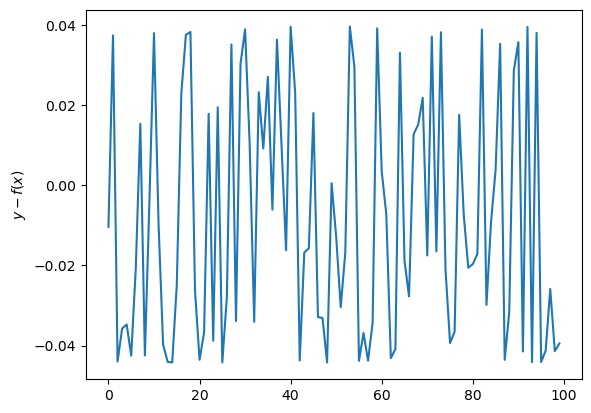

In [ ]:
plt.plot(y-model.predict(X))
plt.ylabel(r'$y-f(x)$')

Let's evaluate the percentage error:

Text(0, 0.5, 'percentage error')

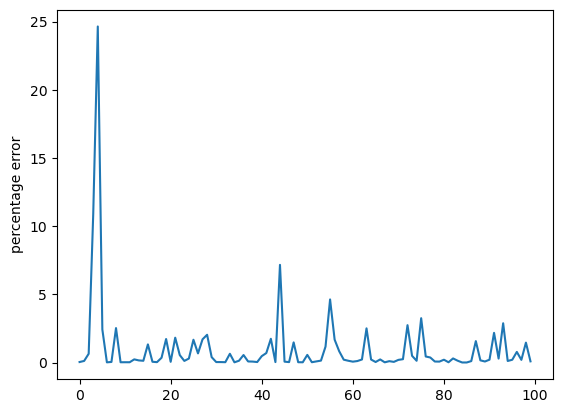

In [ ]:
pc_err = 100*np.abs((y-model.predict(X))/y)
err_mean = np.mean(pc_err)
plt.plot(pc_err)
plt.ylabel('percentage error')

there are few critical points, probably these are the ones near zero, where y is small and so the noise is of the same order or pheraps of an higher order of magnitude of y.

In [ ]:
md(f'The mean value of the percentage error is: {err_mean}')

The mean value of the percentage error is: 1.0055433788304036

# Nice example: tying to interpolate the Debye model

The Debye model for specific heat has this integral form:

$$ c_v(T) = 9R\bigg(\frac{T}{T_D}\bigg)^3 \int_{0}^{\frac{T_D}{T}}\frac{x^4e^x}{(e^x-1)^2}dx$$

where

$$ x = \frac{hv_sn}{2Lk_bT} \quad T_D=\frac{hv_s}{2K_b}\sqrt[3]{\frac{6}{\pi}\frac{N}{V}}$$

if we consider a cube made by iron (L=$1\ m$), we know that $T_D=464\ K$ and $n=2$ because iron is a BCC solid.

/var/folders/b8/p92pmfdj18923_7h6_3fj7nc0000gn/T/ipykernel_7841/2022150869.py:6: RuntimeWarning: overflow encountered in scalar power
  return x**4 *np.exp(x)/ (np.exp(x) - 1)**2


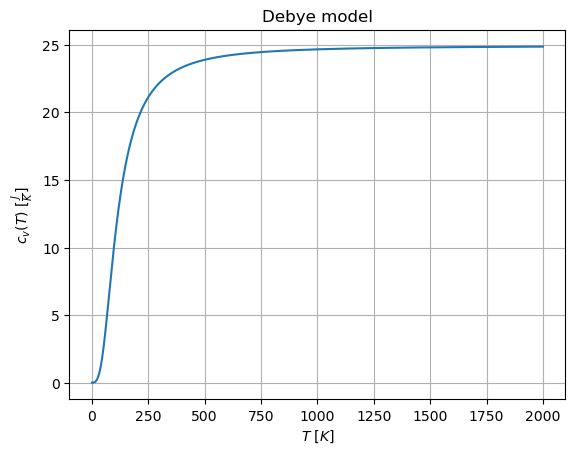

In [ ]:
import numpy as np
from scipy.integrate import quad

T_D = 464
def integrand(x):
    return x**4 *np.exp(x)/ (np.exp(x) - 1)**2

T = np.arange(1, 2000, 0.5)  

def calculate_debye_integral(T):
    result, _ = quad(integrand, 0, T_D/T)
    return result

results = np.vectorize(calculate_debye_integral)(T)
C_v = results*9*8.314*(T/T_D)**3

plt.plot(T,C_v)
plt.xlabel(r"$T\ [K]$")
plt.ylabel(r"$c_v(T)\ [\frac{J}{K}]$")
plt.title("Debye model")
plt.grid(True)
plt.show()


In [ ]:
C_v1 = C_v.reshape(-1, 1)
T1 = T.reshape(-1, 1)

In [ ]:
debyemodel = PySRRegressor(
    niterations=50,  # < Increase me for better results
    binary_operators=["+", "*",'-','/',"^"],
    constraints={'^': (1, 1)},
    nested_constraints={"^": {"^": 2}},
    unary_operators=[
        "exp",
        "log",
        'sinh',
        'cosh',
        'erf',
    ],
    loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
    turbo=True,  
    cluster_manager="lsf",
    multithreading=True,
)


In [ ]:
debyemodel.fit(T1, C_v1)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!

Expressions evaluated per second: 6.000e+04
Head worker occupation: 3.4%
Progress: 106 / 750 total iterations (14.133%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           2.491e+01  1.531e-07  22.847485
4           6.496e+00  4.480e-01  (log(x0) / 0.28724656)
6           6.416e+00  6.181e-03  (log(x0 - 0.87758327) / 0.2872663)
7           6.193e+00  3.546e-02  (log(x0 - log(x0)) / 0.2872663)
8           6.067e+00  2.062e-02  (((log(x0) - 0.7517037) / 0.7517037) / 0.3326383)
9           1.576e+00  1.348e+00  sinh(x0 / ((x0 * 0.25087598) + sinh(2.432785)))
12          1.340e+00  5.411e-02  cosh((x0 - exp(2.055413)) / ((x0 * 0.25126722) + exp(1.2850792...
                                  )))
14          1.297e+00  1.617e-02  cosh((x0 - exp(2.055413)) / ((x0 * 0.25126722) + (cosh(2.05541...
                                  3) - 0.73101896)))
16          1.291e+00

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          22.847485   
	1         0.447960                                log(x0 ^ 3.4814858)   
	2         0.078048                    (log(x0 ^ 4.451175) - 6.546977)   
	3         0.672980           (x0 / ((x0 * 0.037550285) - -2.7555566))   
	4         0.580585           sinh(x0 / ((x0 * 0.2511842) + 5.556373))   
	5         0.006704    sinh(x0 / ((x0 * 0.25087598) + sinh(2.432785)))   
	6         0.176374  sinh((x0 / ((x0 * 0.17634611) + 2.640101)) - 1...   
	7         0.206944  exp(((x0 - sinh(cosh(2.0299697))) / (x0 * 0.21...   
	8         0.000791  exp(((x0 - exp(exp(cosh(0.5378985)))) / (x0 * ...   
	9         2.034451  exp(((x0 - (exp(exp(2.0299697)) / x0)) / (x0 *...   
	10        0.432160  sinh(x0 / ((x0 * sinh(sinh(0.25087598))) + (ex...   
	11        1.195838  sinh(x0 / (((x0 * sinh(0.25087598)) + (exp(sin...   
	12        0.316534  ((cosh(x0 / ((x0 * 0.25087598) + (exp(sinh(2.4...   
	13  >>>>  0.630376  ((cosh(x0 / ((x0 * 0.25087598) + (exp(cosh(2.4...   
	
	         loss  complexity  
	0   24.905958           1  
	1    6.496257           4  
	2    5.557404           6  
	3    2.835310           7  
	4    1.586556           8  
	5    1.575955           9  
	6    1.321130          10  
	7    0.873367          12  
	8    0.872676          13  
	9    0.114104          14  
	10   0.048076          16  
	11   0.014541          17  
	12   0.010595          18  
	13   0.005641          19  
]

In [ ]:
md(f"The model has this equation as output: ${debyemodel.latex()}$")

The model has this equation as output: $0.950 \cosh{\left(\frac{x_{0}}{0.251 x_{0} + \frac{661.}{x_{0}}} \right)} - 0.656$

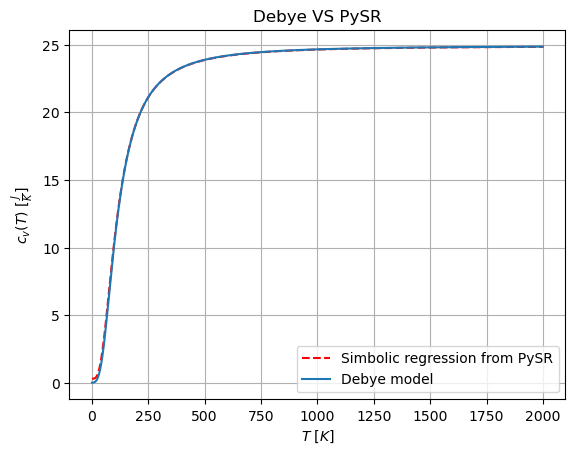

In [ ]:
from scipy.special import erf
#c_v_int = np.exp(np.exp(np.sinh(erf(0.695 * np.log(0.0356 * T))))) - 0.808
#plt.plot(T,c_v_int, label='Simbolic regression from PySR')
c_v_pysr = debyemodel.predict(T1)
plt.plot(T,c_v_pysr,linestyle='--',label='Simbolic regression from PySR', color='r')
plt.plot(T,C_v, label='Debye model')
plt.xlabel(r"$T\ [K]$")
plt.ylabel(r"$c_v(T)\ [\frac{J}{K}]$")
plt.title("Debye VS PySR")
plt.grid(True)
plt.legend()

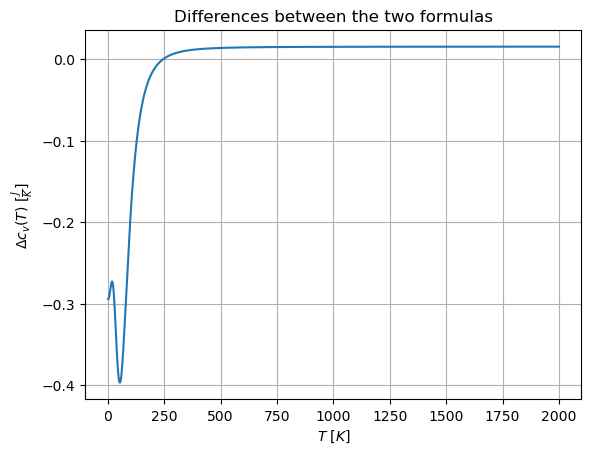

In [ ]:
plt.plot(T,(C_v-c_v_pysr))
plt.title('Differences between the two formulas')
plt.xlabel(r"$T\ [K]$")
plt.ylabel(r"$\Delta c_v(T)\ [\frac{J}{K}]$")
plt.grid(True)


That was a bold try :-)